In [1]:
import numpy as np
import pandas as pd
import lrp
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import seaborn as sns

# Load the dataset and classifier

In [2]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In order to recieve the best results with this LRP implementation, the input data is scaled to the values [-1,...,1]

In [3]:
x_train = (((x_train/255)*2)-1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = (((x_test/255)*2)-1)
x_test = np.expand_dims(x_test, axis=-1)

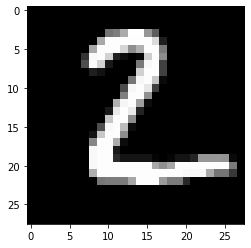

In [4]:
plt.imshow(x_test[1,:,:,0], cmap="gray")

In [6]:
classifier = tf.keras.models.load_model(os.path.join("mnist5.hdf5"))

In [7]:
classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                             

### Create an explainer object

In [8]:
explainer = lrp.LrpExplainer(classifier, 
                             ["final", "ab", "avg", "ab", "ab", "avg", "flatten", "eps", "0"], #this LRP process must define a rule for each layer. for reference what rule to choose, see here: https://iphome.hhi.de/samek/pdf/MonXAI19.pdf
                             a = 2, b = -1,  #These are hyper parameters a & b, according to LRP specificationsw
                             verbose = True) #Enables additional printouts and returns of the relprop function

### As verbose is True, additional logs are printed and returned

In [11]:
img = x_test[1,...]
label = np.eye(10)[y_test[1],:]

In [12]:
R, inputs, outputs, weights, biases, rs = explainer.relprop(img, label)

calculating LRP of  <keras.engine.functional.Functional object at 0x000001D2AF9313A0>
['final', 'ab', 'avg', 'ab', 'ab', 'avg', 'flatten', 'eps', '0']
###################
getting values
propagating relevance regarding classification:  2
In layer  -1  :  <keras.layers.core.dense.Dense object at 0x000001D2BDB86B20>  check-value:  0.9979440753842187
In layer  -2  :  <keras.layers.core.dense.Dense object at 0x000001D2BDB7EAF0>  check-value:  0.9990285030862329
In layer  -3  :  <keras.layers.core.flatten.Flatten object at 0x000001D2BDB7EDF0>  check-value:  0.9990285030862329
In layer  -4  :  <keras.layers.pooling.MaxPooling2D object at 0x000001D2BDB7E940>  check-value:  0.9990285030862327
In layer  -5  :  <keras.layers.convolutional.Conv2D object at 0x000001D2BDB78A00>  check-value:  0.9990285
In layer  -6  :  <keras.layers.convolutional.Conv2D object at 0x000001D2BDB6D5E0>  check-value:  0.99902856
In layer  -7  :  <keras.layers.pooling.MaxPooling2D object at 0x000001D2BDB6D7F0>  check-val

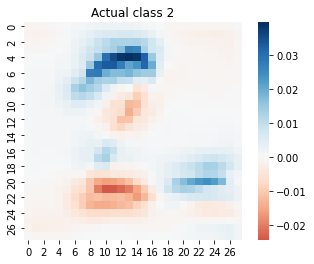

In [13]:
sns.heatmap(((R.sum(axis=3)[0,:,:])),center=0, vmax=np.max(R.sum(axis=3)[0,:,:]), vmin=np.min(R.sum(axis=3)[0,:,:]),cmap="RdBu", square=True)
_=plt.title("Actual class "+str(np.argmax(label)))

## Creating an adversarial attack and checking out the result

For the sake of this demonstration, we set verbose to False as to not get too many relprop log printouts

In [16]:
explainer = lrp.LrpExplainer(classifier, 
                             ["final", "ab", "avg", "ab", "ab", "avg", "flatten", "eps", "0"], #this LRP process must define a rule for each layer. for reference what rule to choose, see here: https://iphome.hhi.de/samek/pdf/MonXAI19.pdf
                             a = 2, b = -1,  #These are hyper parameters a & b, according to LRP specificationsw
                             verbose = False) #Enables additional printouts and returns of the relprop function

In [46]:
adv_img_flip = explainer.flip_attack(img, label, flips = 100)
adv_img_ifgsm = explainer.ifgsm_attack(img, label, flips = 100, eps = 2/256)
adv_img_lrp = explainer.lrp_attack_batch_grad(img, label, flips = 100, batch = 20, eps = 2/256)
adv_imgs = dict({"flip": adv_img_flip, "ifgsm": adv_img_ifgsm, "lrp": adv_img_lrp})

In [48]:
adv_imgs.keys()

dict_keys(['flip', 'ifgsm', 'lrp'])

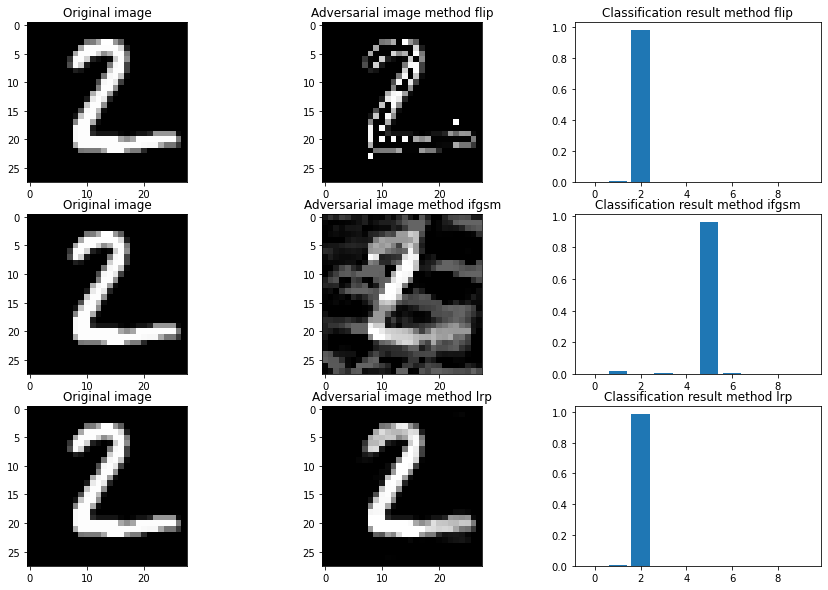

In [51]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (15,10))

for i, method in enumerate(adv_imgs.keys()):
    axs[i,0].imshow(img, cmap = "gray")
    axs[i,0].set_title("Original image")
    axs[i,1].imshow(adv_imgs[method], cmap = "gray")
    axs[i,1].set_title(f"Adversarial image method {method}")
    axs[i,2].bar(range(0,10), classifier.predict(adv_imgs[method].reshape([1]+ list(adv_imgs[method].shape)))[0])
    axs[i,2].set_title(f"Classification result method {method}")